In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

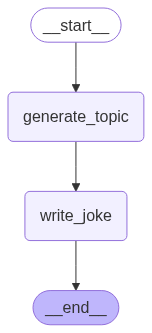

In [ ]:
import uuid

from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, START, StateGraph

from typing import Annotated
from __future__ import annotations


from collections.abc import Sequence
from dataclasses import dataclass, field
from typing import Annotated

from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages


class State:
    Annotated[Sequence[AnyMessage], add_messages] = field(default_factory=list)


llm = init_chat_model(
    "azure_openai:gpt-4o",
    temperature=0,
)


def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    msg = llm.invoke("Give me a funny topic for a joke")
    return {"topic": msg.content}


def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
graph

In [2]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
state = graph.invoke({}, config)

print(state["topic"])
print()
print(state["joke"])

How about this: "Why do cows have hooves instead of feet?"

Why do cows have hooves instead of feet? Because they lactose!


In [3]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

for state in states:
    print(state)
    print()

StateSnapshot(values={'topic': 'How about this: "Why do cows have hooves instead of feet?"', 'joke': 'Why do cows have hooves instead of feet? Because they lactose!'}, next=(), config={'configurable': {'thread_id': 'f99096d8-5db5-46d5-9658-ada25c74d093', 'checkpoint_ns': '', 'checkpoint_id': '1f05b628-8380-6567-8002-4b07fb25d9c0'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}, 'thread_id': 'f99096d8-5db5-46d5-9658-ada25c74d093'}, created_at='2025-07-07T18:45:19.878065+00:00', parent_config={'configurable': {'thread_id': 'f99096d8-5db5-46d5-9658-ada25c74d093', 'checkpoint_ns': '', 'checkpoint_id': '1f05b628-7ef2-6cf7-8001-33b58661e964'}}, tasks=(), interrupts=())

StateSnapshot(values={'topic': 'How about this: "Why do cows have hooves instead of feet?"'}, next=('write_joke',), config={'configurable': {'thread_id': 'f99096d8-5db5-46d5-9658-ada25c74d093', 'checkpoint_ns': '', 'checkpoint_id': '1f05b628-7ef2-6cf7-8001-33b58661e964'}}, metadata={'source': 'loop', 'step': 1, 'paren

In [4]:
# This is the state before last (states are listed in chronological order)
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

('write_joke',)
{'topic': 'How about this: "Why do cows have hooves instead of feet?"'}


In [5]:
new_config = graph.update_state(selected_state.config, values={"topic": "chickens"})
print(new_config)

{'configurable': {'thread_id': 'f99096d8-5db5-46d5-9658-ada25c74d093', 'checkpoint_ns': '', 'checkpoint_id': '1f05b62f-ed42-698b-8002-04c73ce11051'}}


In [6]:
graph.invoke(None, new_config)

{'topic': 'chickens',
 'joke': 'Why did the chicken join a band? Because it had the drumsticks!'}

In [8]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

for state in states:
    print(state.values)
    print()

{'topic': 'chickens', 'joke': 'Why did the chicken join a band? Because it had the drumsticks!'}

{'topic': 'chickens'}

{'topic': 'How about this: "Why do cows have hooves instead of feet?"', 'joke': 'Why do cows have hooves instead of feet? Because they lactose!'}

{'topic': 'How about this: "Why do cows have hooves instead of feet?"'}

{}

{}

